In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.dates as mdates

def detect_outliers_arima(csv_file, N=1, p=1, d=1, q=1, forecast_steps=10, threshold_factor=2, start_date=None, end_date=None, output_file=None):
    """
    CSV 파일을 로드하고, N일 단위로 데이터를 집계하여 ARIMA 모델을 학습하고,
    예측값과 실제값의 차이를 기준으로 이상치를 검출하는 함수.

    Parameters:
    - csv_file (str): 리뷰 데이터가 저장된 CSV 파일 경로.
    - N (int): 데이터 집계를 위한 일수 (예: N=3이면 3일 단위로 집계).
    - p (int): ARIMA 모델의 p 값 (자기회귀 차수).
    - d (int): ARIMA 모델의 d 값 (차분 차수).
    - q (int): ARIMA 모델의 q 값 (이동평균 차수).
    - forecast_steps (int): 예측할 기간 (3일 단위).
    - threshold_factor (float): 이상치 판별 기준 (표준편차의 몇 배 이상을 이상치로 볼지).
    - start_date (str): 분석을 시작할 날짜 ('YYYY-MM-DD' 형식).
    - end_date (str): 분석을 끝낼 날짜 ('YYYY-MM-DD' 형식).
    - output_file (str): 이상치를 저장할 CSV 파일 이름 (없으면 저장 안됨).

    Returns:
    - outliers (pd.Series): 이상치가 있는 기간과 그 값.
    """
    # CSV 파일 로드
    df = pd.read_csv(csv_file)

    # 데이터 컬럼 확인
    print("컬럼명:", df.columns)

    # 날짜 컬럼을 datetime 형식으로 변환 (오류가 있을 경우 NaT로 처리)
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    print(f"최소 날짜: {df['date'].min()}")  # 데이터 범위 확인

    # 잘못된 날짜 값은 제거
    df = df.dropna(subset=['date'])

    if df.empty:
        print("데이터에 유효한 날짜가 없습니다.")
        return pd.Series()  # 빈 시리즈 반환

    # 날짜 컬럼을 인덱스로 설정
    df.set_index('date', inplace=True)

    # 주어진 기간 동안의 데이터만 필터링
    if start_date:
        df = df[df.index >= pd.to_datetime(start_date)]

    if df.empty:
        # 주어진 start_date 이후의 데이터가 없으면, 가장 빠른 유효한 날짜로 시작
        next_valid_date = df.index.min()
        print(f"주어진 날짜 범위({start_date})에 해당하는 데이터가 없으므로, 가장 빠른 유효한 날짜({next_valid_date}) 이후로 시작합니다.")
        df = df[df.index >= next_valid_date]

    if end_date:
        df = df[df.index <= pd.to_datetime(end_date)]

    if df.empty:
        print(f"주어진 날짜 범위({start_date} - {end_date})에 해당하는 데이터가 없습니다.")
        return pd.Series()  # 빈 시리즈 반환

    # 각 날짜별 리뷰 개수 집계
    df_resampled = df.resample(f'{N}D').size()  # N일 간격으로 리뷰 수를 집계
    df_resampled = df_resampled.to_frame(name='review_count')  # 컬럼명을 'review_count'로 변경

    if df_resampled.empty:
        print(f"{N}일 단위로 집계한 데이터가 없습니다.")
        return pd.Series()  # 빈 시리즈 반환

    # 전체 리뷰 수 출력 (start_date부터 end_date까지)
    total_reviews = df_resampled['review_count'].sum()
    print(f"기간 동안의 전체 리뷰 수 ({start_date} - {end_date}): {total_reviews}개")

    # ADF 검정으로 정상성 확인
    result = adfuller(df_resampled['review_count'])
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")

    if result[1] > 0.05:
        # 데이터가 정상적이지 않으면 차분을 통해 정상화
        df_diff = df_resampled['review_count'].diff().dropna()
        result = adfuller(df_diff)
        print(f"ADF Statistic after differencing: {result[0]}")
        print(f"p-value after differencing: {result[1]}")

    # ARIMA 모델 학습
    model = ARIMA(df_resampled['review_count'], order=(p, d, q))
    model_fit = model.fit()

    # 예측값 계산
    forecast = model_fit.forecast(steps=forecast_steps)
    forecast_index = pd.date_range(df_resampled.index[-1] + pd.Timedelta(days=N), periods=forecast_steps, freq=f'{N}D')

    # 예측값 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(df_resampled.index, df_resampled['review_count'], label='Actual Reviews')
    plt.plot(forecast_index, forecast, label='Forecasted Reviews', color='red')

    # x축 날짜 라벨 포맷 설정
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # 월별로 라벨을 표시
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 년-월 형식으로 표시
    plt.gcf().autofmt_xdate()  # 날짜 라벨 회전

    plt.title("ARIMA Model - Reviews Count")
    plt.xlabel("Date")
    plt.ylabel("Review Count")
    plt.legend()
    plt.tight_layout()  # 그래프 여백 조정
    plt.show()

    # 잔차 계산 (실제 값 - 예측 값)
    residuals = df_resampled['review_count'] - model_fit.fittedvalues

    # 이상치 기준 설정: 예측값과 실제값의 차이가 표준편차의 threshold_factor배 이상인 경우 이상치로 설정
    threshold = threshold_factor * residuals.std()
    outliers = residuals[residuals.abs() > threshold]

    print("Detected outliers:")
    print(outliers)


    # 이상치 날짜와 그에 해당하는 리뷰 수를 출력
    if not outliers.empty:
        outlier_dates = outliers.index
        outlier_reviews = df_resampled.loc[outlier_dates, 'review_count']
        print("\nOutlier Dates and Corresponding Review Counts:")
        print(pd.DataFrame({'Outlier Date': outlier_dates, 'Review Count': outlier_reviews}))

        # 이상치 날짜의 개수 출력
        print(f"\nTotal number of outlier dates: {len(outlier_dates)}")

        # CSV로 저장
        if output_file:
            outliers_df = pd.DataFrame({
                'Outlier Date': outlier_dates,
                'Review Count': outlier_reviews
            })
            outliers_df.to_csv(output_file, index=False)
            print(f"Outliers saved to {output_file}")

    return outliers


In [7]:
# 함수 사용 예시:

outliers = detect_outliers_arima(
    csv_file='/content/drive/MyDrive/PML_PAPRER/data/1_2_Processed_SuperSol.csv',  # CSV 파일 경로
    N=1,                          # 3일 단위로 집계
    p=1,                          # ARIMA 모델의 p 값
    d=1,                          # ARIMA 모델의 d 값
    q=1,                          # ARIMA 모델의 q 값
    forecast_steps=10,            # 10일 동안 예측
    threshold_factor=2,           # 이상치 판별 기준 (표준편차의 2배 이상)
    start_date='2023-12-8',      # 분석 시작 날짜
    # end_date='2023-06-30',        # 분석 종료 날짜
    output_file='/content/drive/MyDrive/PML_PAPRER/data/2_Arima_SuperSol.csv'    # 이상치 정보를 저장할 파일 이름
)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/PML_PAPRER/data/1_2_Processed_SuperSol.csv'

컬럼명: Index(['date', 'score', 'content', 'tokens', 'nouns', 'adj'], dtype='object')
최소 날짜: 2023-12-08 01:43:55
기간 동안의 전체 리뷰 수 (2018-02-22 - None): 2412개
ADF Statistic: -3.635587572623637
p-value: 0.005116004318452428


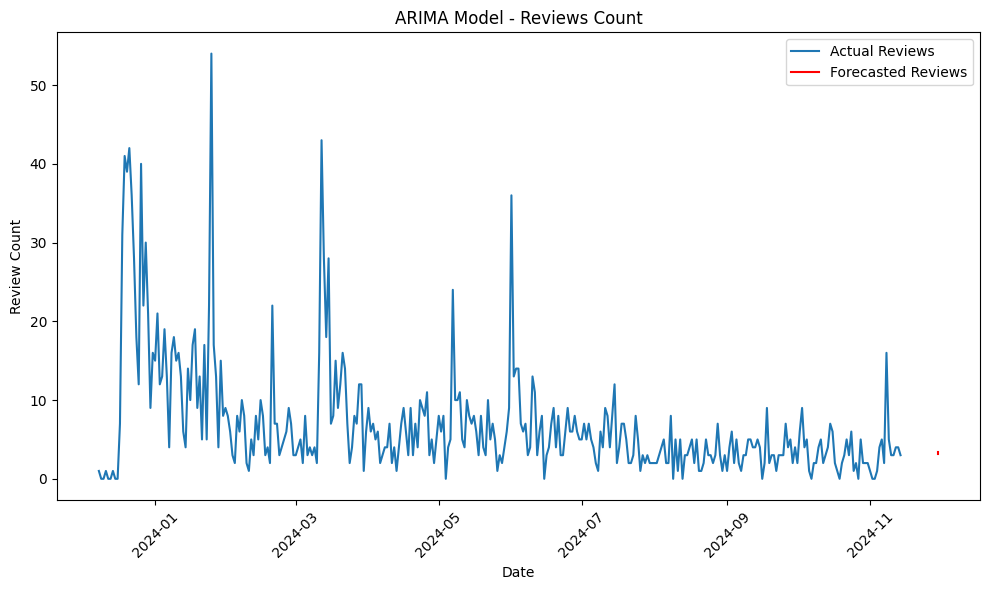

Detected outliers:
date
2023-12-18    26.421084
2023-12-19    21.184473
2023-12-20    12.141229
2023-12-21    15.396714
2023-12-26    27.155588
2024-01-24    13.080020
2024-01-25    35.312306
2024-01-26   -20.428514
2024-02-20    16.350962
2024-03-12    30.384731
2024-03-15    13.419860
2024-03-16   -13.483613
2024-05-07    18.192009
2024-06-01    28.034586
2024-11-08    13.565816
dtype: float64

Outlier Dates and Corresponding Review Counts:
           Outlier Date  Review Count
date                                 
2023-12-18   2023-12-18            31
2023-12-19   2023-12-19            41
2023-12-20   2023-12-20            39
2023-12-21   2023-12-21            42
2023-12-26   2023-12-26            40
2024-01-24   2024-01-24            22
2024-01-25   2024-01-25            54
2024-01-26   2024-01-26            17
2024-02-20   2024-02-20            22
2024-03-12   2024-03-12            43
2024-03-15   2024-03-15            28
2024-03-16   2024-03-16             7
2024-05-07   2024-05-

In [ ]:
# 함수 사용 예시:

outliers = detect_outliers_arima(
    csv_file='/content/drive/MyDrive/PML_PAPRER/data/1_2_Processed_SuperSol.csv',  # CSV 파일 경로
    N=1,                          # 3일 단위로 집계
    p=1,                          # ARIMA 모델의 p 값
    d=1,                          # ARIMA 모델의 d 값
    q=1,                          # ARIMA 모델의 q 값
    forecast_steps=10,            # 10일 동안 예측
    threshold_factor=2,           # 이상치 판별 기준 (표준편차의 2배 이상)
    start_date='2018-02-22',      # 분석 시작 날짜
    # end_date='2023-06-30',        # 분석 종료 날짜
    output_file='/content/drive/MyDrive/PML_PAPRER/data/2_Arima_SolBank.csv'    # 이상치 정보를 저장할 파일 이름
)

# 이상치 출력
print("Detected Outliers:")
print(outliers)


컬럼명: Index(['date', 'score', 'content', 'tokens', 'nouns', 'adj'], dtype='object')
최소 날짜: 2022-10-27 00:02:45
기간 동안의 전체 리뷰 수 (2022-10-27 - None): 11842개
ADF Statistic: -3.836075211026198
p-value: 0.00255904995127534


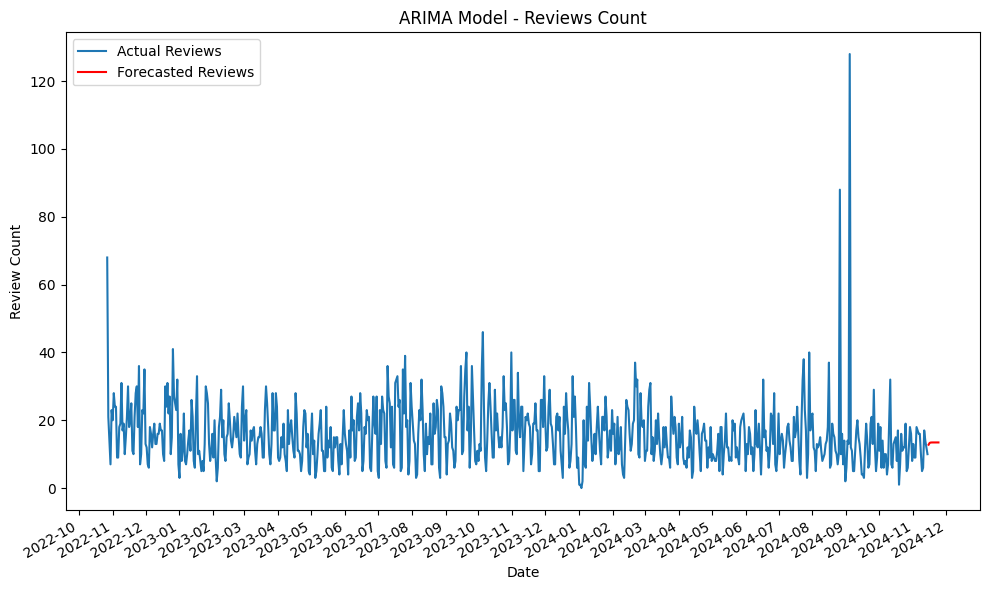

Detected outliers:
date
2022-10-27     68.000000
2022-10-28    -46.996124
2022-10-29    -25.937479
2022-10-30    -24.124543
2022-12-26     22.684109
2023-07-10     22.741494
2023-07-24     20.798656
2023-07-26     21.328702
2023-09-20     19.341562
2023-10-05     25.192728
2023-10-31     22.447416
2024-02-21     20.216654
2024-07-24     20.212332
2024-07-29     26.317501
2024-08-16     21.783310
2024-08-26     74.473134
2024-08-27    -19.859452
2024-09-04    113.448421
2024-09-05    -26.690947
dtype: float64

Outlier Dates and Corresponding Review Counts:
           Outlier Date  Review Count
date                                 
2022-10-27   2022-10-27            68
2022-10-28   2022-10-28            21
2022-10-29   2022-10-29            14
2022-10-30   2022-10-30             7
2022-12-26   2022-12-26            41
2023-07-10   2023-07-10            36
2023-07-24   2023-07-24            35
2023-07-26   2023-07-26            39
2023-09-20   2023-09-20            40
2023-10-05   2023-10

In [18]:
outliers = detect_outliers_arima(
    csv_file='/content/drive/MyDrive/PML_PAPER/data/1_2_Processed_KBstar_Sentences.csv',  # CSV 파일 경로
    N=1,                          # 3일 단위로 집계
    p=1,                          # ARIMA 모델의 p 값
    d=1,                          # ARIMA 모델의 d 값
    q=1,                          # ARIMA 모델의 q 값
    forecast_steps=10,            # 10일 동안 예측
    threshold_factor=2,           # 이상치 판별 기준 (표준편차의 2배 이상)
    start_date='2022-10-27',      # 분석 시작 날짜
    # end_date='2023-06-30',        # 분석 종료 날짜
    output_file='/content/drive/MyDrive/PML_PAPER/data/2_Arima_KBstar.csv'    # 이상치 정보를 저장할 파일 이름
)

# 이상치 출력
print("Detected Outliers:")
print(outliers)

'''
2023-12-14
2023-12-20
2024-02-09
2024-02-18
2024-03-10
2024-03-13
2024-07-29
2024-09-03
2024-10-06
2024-10-18
2024-11-02
'''